## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [ ]:
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications import NASNetLarge
from keras.models import Model


# Process data and augmetation

In [ ]:
train_data_dir = '/content/drive/MyDrive/FL/classification_cataract/dataset/train'
val_data_dir = '/content/drive/MyDrive/FL/classification_cataract/dataset/test'

#image size
img_width = 331
img_height = 331
batch_size = 8

# Augmentation data
train_datagen = ImageDataGenerator(
    rescale=1/255.0, #rescale image
    horizontal_flip=True, #flip image
    rotation_range=45, #rotation
    width_shift_range=0.2, #shift
    shear_range=0.2, #shear
    zoom_range=0.1, #zoom
    brightness_range=[0.8,1.2], #random brightness
    )
val_datagen = ImageDataGenerator(
    rescale=1/255.0, #rescale image   
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.1,
    brightness_range=[0.8,1.2],
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=20
    ) 

validation_generator = val_datagen.flow_from_directory(
    val_data_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=20
    )

test_generator = val_datagen.flow_from_directory(
    val_data_dir, 
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=20
    )

Found 233 images belonging to 3 classes.
Found 51 images belonging to 3 classes.
Found 51 images belonging to 3 classes.


## Pretrained model NASNetLarge
weight=imagenet and remove top layer

In [ ]:
pre_train_model = NASNetLarge( # pretrained model
      include_top = False,
      weights = 'imagenet',
      input_shape = (img_width, img_height, 3)
)

343610240/343610240 [==============================] - 16s 0us/step


#### Freeze all layers to train on top layers

In [ ]:
pre_train_model.trainable = False
last_output = pre_train_model.output

In [ ]:
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

#### Custom top layers

In [ ]:
x = Flatten()(last_output)
x = Dense(512, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x) #dense 3 because 3 classes, and activation is softmax

In [ ]:
# Define optimizer, learning rate and loss function
model = Model(pre_train_model.input, output)
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])

#### Class_weight because dataset is imbalanced

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_generator.classes), y=train_generator.classes)

In [ ]:
class_weights = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}

In [ ]:
#Save max accuracy model using callbacks

myCallbacks = [
    keras.callbacks.EarlyStopping(monitor='val_acc',patience=10),
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/classification_cataract/logs/model_{val_acc:.2f}.h5',
                                    monitor='val_acc',mode='max',save_best_only=True)    
]

In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_validation = validation_generator.n//validation_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size


# Train model

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch = step_size_train,
      epochs = 100, #change it
      shuffle=False,
      verbose = 1,
      validation_data = validation_generator,
      validation_steps = step_size_validation,
      callbacks= myCallbacks,
      # class_weight = class_weights
      )

Epoch 1/60
29/29 [==============================] - 234s 7s/step - loss: 1.8880 - acc: 0.4655 - val_loss: 1.1432 - val_acc: 0.5417
Epoch 2/60
29/29 [==============================] - 33s 1s/step - loss: 1.1571 - acc: 0.6379 - val_loss: 0.8931 - val_acc: 0.6458
Epoch 3/60
29/29 [==============================] - 15s 516ms/step - loss: 0.8869 - acc: 0.6164 - val_loss: 1.1980 - val_acc: 0.6458
Epoch 4/60
29/29 [==============================] - 34s 1s/step - loss: 0.8249 - acc: 0.7198 - val_loss: 0.7549 - val_acc: 0.6875
Epoch 5/60
29/29 [==============================] - 15s 508ms/step - loss: 0.6365 - acc: 0.7888 - val_loss: 1.0032 - val_acc: 0.5833
Epoch 6/60
29/29 [==============================] - 36s 1s/step - loss: 0.6592 - acc: 0.7802 - val_loss: 0.9298 - val_acc: 0.7292
Epoch 7/60
29/29 [==============================] - 15s 491ms/step - loss: 0.7063 - acc: 0.7543 - val_loss: 1.2589 - val_acc: 0.6250
Epoch 8/60
29/29 [==============================] - 14s 474ms/step - loss: 0.681

# Metric

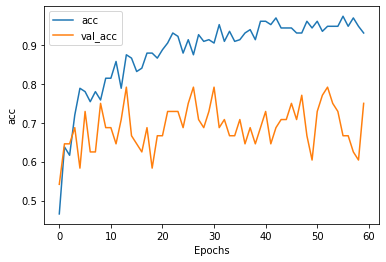

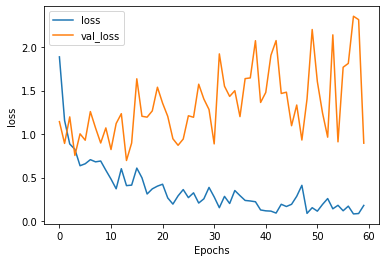

In [ ]:
#Visualize Training
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.savefig('/content/drive/MyDrive/FL/classification_cataract/logs/' + string + '.png')

    plt.show()
plot_graphs(history,'acc')
plot_graphs(history,'loss')

In [ ]:
#test model
loss= model.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

51/51 [==============================] - 4s 66ms/step - loss: 1.6051 - acc: 0.7843
loss test: 1.61
accuracy test: 0.78


# Load model

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/FL/classification_cataract/logs/model_0.81.h5')

51/51 [==============================] - 10s 78ms/step


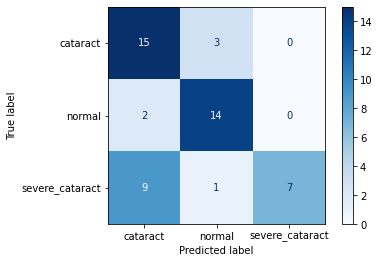

In [ ]:
class_labels = list(test_generator.class_indices.keys()) #2 classes

from sklearn import metrics
#Confution Matrix
Y_pred = model.predict(test_generator, step_size_validation // batch_size+1) #predict
y_pred = np.argmax(Y_pred, axis=1)
cm = metrics.confusion_matrix(test_generator.classes, y_pred) #confusion matrix

class_labels = list(test_generator.class_indices.keys()) 
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels) #plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.savefig('/content/drive/MyDrive/classification_cataract/logs/confusion_matrix.png')
plt.show()

In [ ]:
results = model.predict(test_generator, steps=test_generator.n) #predict
predicted_classes = np.argmax(results, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels) #print report
print(report)

51/51 [==============================] - 3s 59ms/step
                 precision    recall  f1-score   support

       cataract       0.57      0.72      0.63        18
         normal       0.74      0.88      0.80        16
severe_cataract       0.67      0.35      0.46        17

       accuracy                           0.65        51
      macro avg       0.66      0.65      0.63        51
   weighted avg       0.65      0.65      0.63        51



# Test model

In [ ]:
img_width = 331
img_height = 331

In [ ]:
import os
from PIL import Image

labels = {'cataract': 0, 'normal': 1, 'severe_cataract': 2}
labels = dict((v,k) for k,v in labels.items())
data_path = '/content/drive/MyDrive/classification_cataract/dataset/test/normal'
for img_name in os.listdir(data_path):
  img_path = os.path.join(data_path, img_name)
  im = Image.open(img_path).convert('RGB').resize((img_width, img_height)) #read image
  print(img_name)
  im = np.array(im)
  im = im.reshape(1,img_width, img_height,3) #reshape image size
  result = model.predict(im/255, verbose=0) #predict
  predicted_class_indices=np.argmax(result,axis=1)
  
  predictions = [labels[k] for k in predicted_class_indices]
  print("Predicted class: ",predictions[0])

image10.jpg
Predicted class:  normal
image7.jpg
Predicted class:  normal
image5.jpg
Predicted class:  normal
image9.jpg
Predicted class:  normal
image2.jpg
Predicted class:  normal
image3.jpg
Predicted class:  normal
istockphoto-1164197228-612x612.jpg
Predicted class:  normal
istockphoto-1171118216-612x612.jpg
Predicted class:  normal
image6.jpg
Predicted class:  normal
image4.jpg
Predicted class:  normal
image1.jpg
Predicted class:  cataract
istockphoto-472682408-612x612.jpg
Predicted class:  cataract
image8.jpg
Predicted class:  normal
istockphoto-1140598293-612x612.jpg
Predicted class:  normal
image0.jpg
Predicted class:  normal
istockphoto-1139091656-612x612.jpg
Predicted class:  normal


1/1 [==============================] - 0s 51ms/step
Predicted class:  severe_cataract


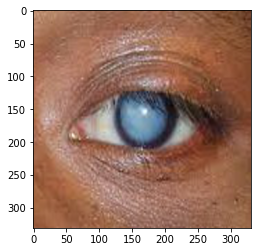

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow

image_path = "/content/drive/MyDrive/classification_cataract/dataset/test/severe_cataract/image176.jpg"
im = Image.open(image_path).convert('RGB').resize((img_width, img_height))
imshow(np.asarray(im))
im = np.array(im)
im = im.reshape(1,img_width, img_height,3)
result = model.predict(im/255)
predicted_class_indices=np.argmax(result,axis=1)
labels = {'cataract': 0, 'normal': 1, 'severe_cataract': 2}
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print("Predicted class: ",predictions[0])

In [ ]:
#https://keras.io/api/applications/nasnet/
#https://www.kaggle.com/datasets/lokeshrth4617/cataracts1
#https://analyticsindiamag.com/a-tutorial-on-sequential-machine-learning/#:~:text=What%20is%20The%20Sequential%20Learning,are%20examples%20of%20sequential%20data.

